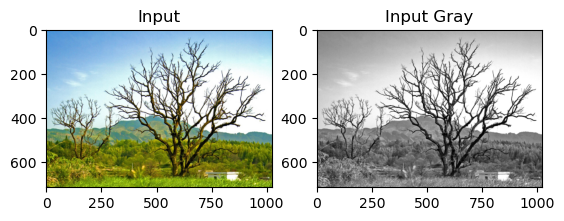

In [1]:
import cv2
import math
import numpy as np
from gen_edge_strokes import *
from disp_hist import *
from matplotlib import pyplot as plt
from skimage import filters, transform,exposure
from scipy import signal

cv2.saliency

##input
id='5--32'
image = cv2.imread('inputs/'+id+'.jpg')
scale_percent = 100 # percent of original size
height = int(image.shape[0] * scale_percent / 100)
width = int(image.shape[1] * scale_percent / 100)

dim = (width, height)

image= cv2.resize(image, dim) #redimensionar
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) ##grises

gray=gray.astype(float)
gray=filters.gaussian(gray,0.2, truncate=2)

ax1=plt.subplot(221)
ax1.imshow(image,cmap='gray')
ax1.set_title('Input')
ax2=plt.subplot(222)
ax2.imshow(gray,cmap='gray')
ax2.set_title('Input Gray')
plt.show()

## Saliency

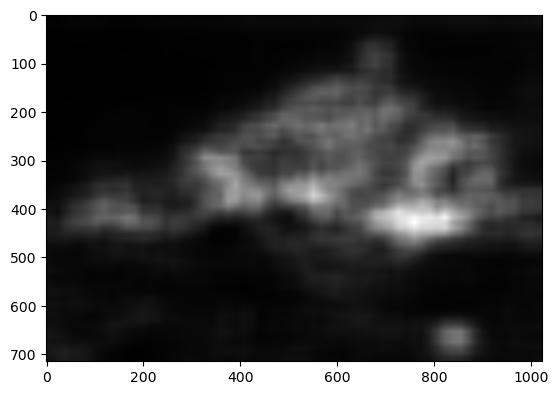

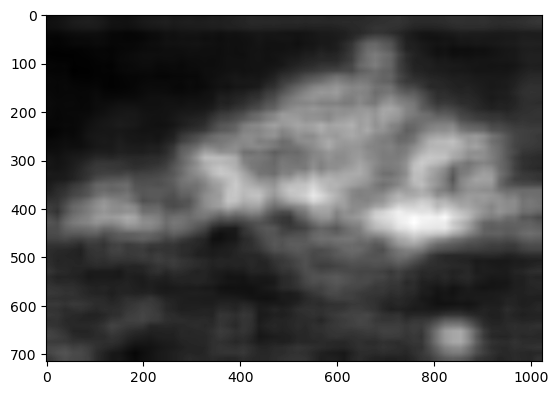

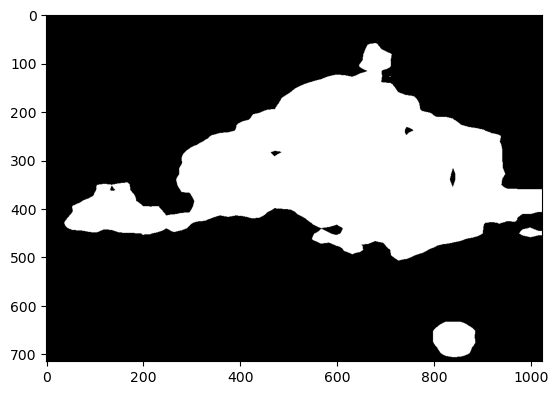

732160


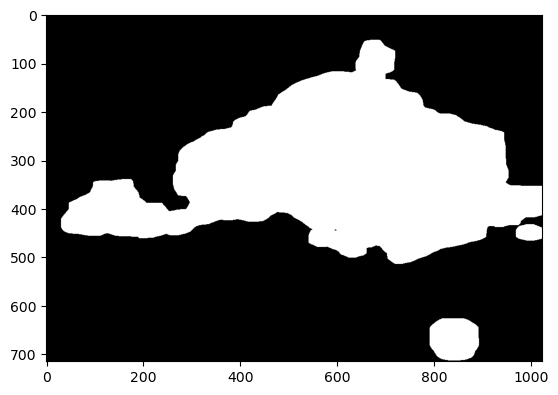

In [2]:
from skimage import morphology
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(image)
#saliencyMap = (saliencyMap * 255).astype("uint8")
salMap=np.sqrt(saliencyMap)
salMap=filters.gaussian(salMap,0.2, truncate=2)
(suc, binMap) = saliency.computeBinaryMap(salMap)
plt.imshow(saliencyMap, cmap='gray')
plt.show()
plt.imshow(salMap, cmap='gray')
plt.show()
plt.imshow(binMap, cmap='gray')
plt.show()

print(salMap.size)

binMap_b=filters.gaussian(binMap,0.2,truncate=2)

binMap_b=morphology.binary_erosion(binMap_b)
binMap_b=morphology.binary_dilation(binMap_b)

binMap_b = np.asarray(binMap_b, dtype="uint8")
kernel = np.ones((15,15),np.uint8)
binMap_b = cv2.dilate(binMap_b,kernel,iterations = 1)

plt.imshow(binMap_b, cmap='gray')
plt.show()


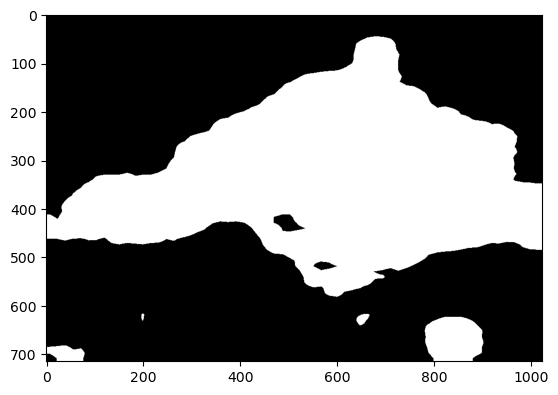

In [3]:
binMap_t=salMap.copy()
binMap_t[binMap_t>=0.3]=1
binMap_t[binMap_t<0.3]=0
plt.imshow(binMap_t, cmap='gray')
plt.show()


# Multi res contrast pyramid

In [4]:
from get_gp import get_gp

def get_mr_img(gp, draw_mp):
    """
    Return an image from a gaussian pyramid
    """
    n = len(gp)
    r = draw_mp * (n-1)
    rin = r.astype(int)
    a = r - rin
    # rin = 3 - rin

    z = tuple(np.indices((gp[0].shape[0], gp[0].shape[1])))
    # print('a', a.shape, 'r', r.shape, 'rin', rin.shape, 'gp', gp.shape, 'z', z[0].shape, z[1].shape)
    next_m = rin+1
    next_m[next_m==n] = n-1
    # print(np.amax(rin), np.amax(r), n)
    # print('gprin', gp[(rin,) + z].shape)

    out = (1-a) * gp[(rin,) + z] + a * gp[(next_m,)+z]
    return out


(715, 1024)
(715, 1024)
(715, 1024)
(715, 1024)


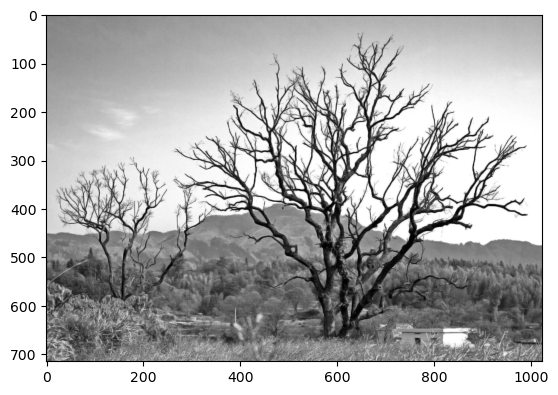

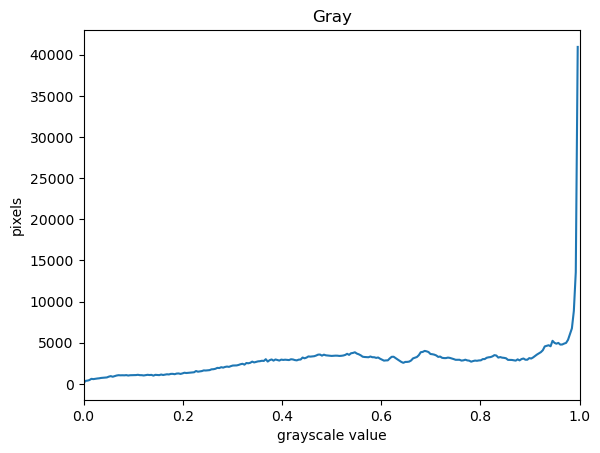

In [5]:
d_map=salMap
mc_gauss_py = [gray]
get_gp(gray, mc_gauss_py, 2, sm_size=True)

[print (i.shape) for i in mc_gauss_py]
mc_gauss_py_arr= np.array(mc_gauss_py)
mres = get_mr_img(mc_gauss_py_arr, d_map)

plt.imshow(gray, cmap='gray')
plt.show()
disp_hist(gray/255, 'Gray')


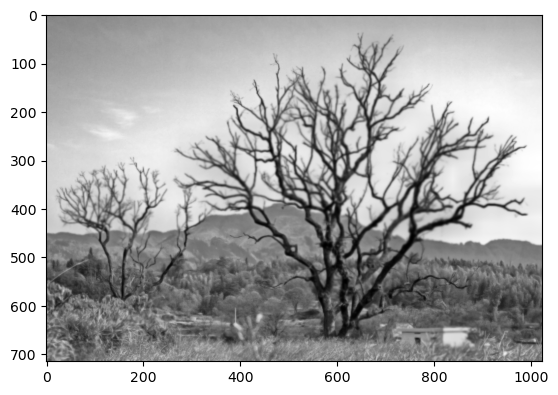

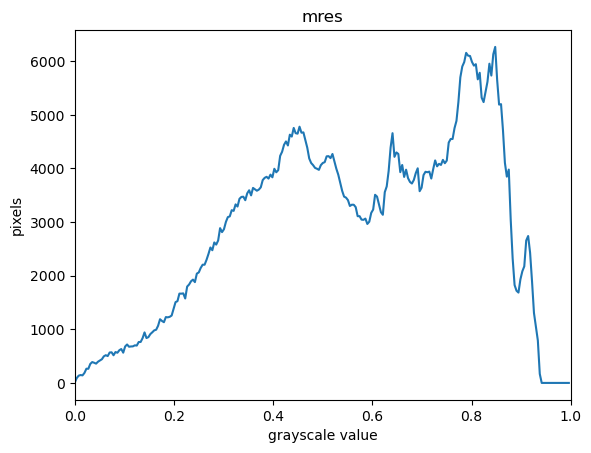

In [6]:
plt.imshow(mres, cmap='gray')
plt.show()
disp_hist(mres/255, 'mres')

## EDGE

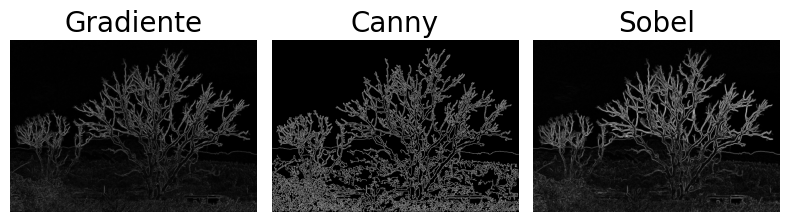

witch multi-res map:



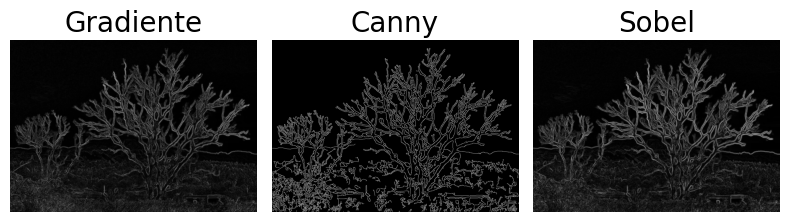

In [7]:
##Bordes
####0=gradiente, 1=canny, 2=sobel
edges=gen_edge(gray,method=0, display=True)
print('witch multi-res map:\n')
edges_mres=gen_edge(mres,method=0, display=True)


## STROKE

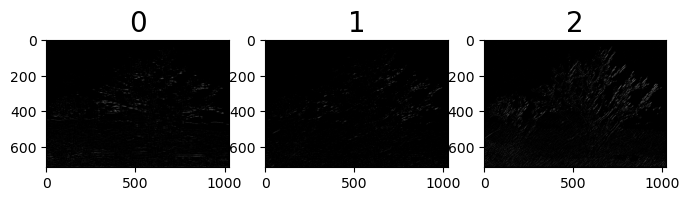

witch multi-res map:



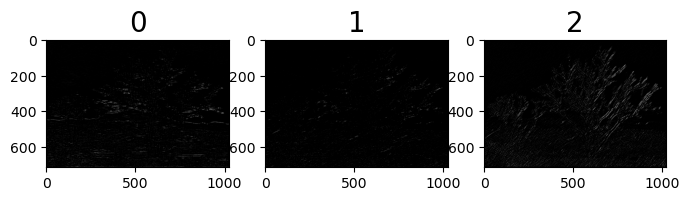

In [8]:
##STROKE 
LS= 11#int(height*(1/30))
strokes=gen_strokes(edges, lineSize=LS,lineWidth=0, display=True)
print('witch multi-res map:\n')
strokes_mres=gen_strokes(edges_mres, lineSize=LS,lineWidth=0, display=True)


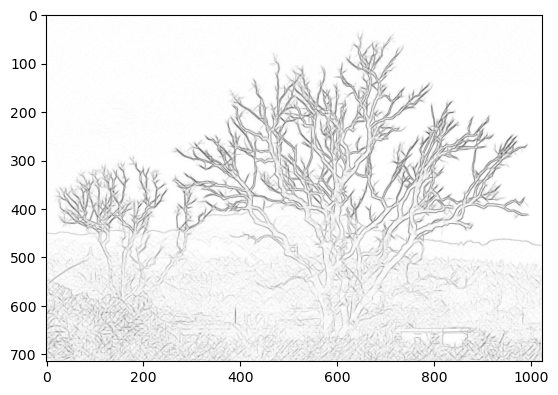

witch multi-res map:



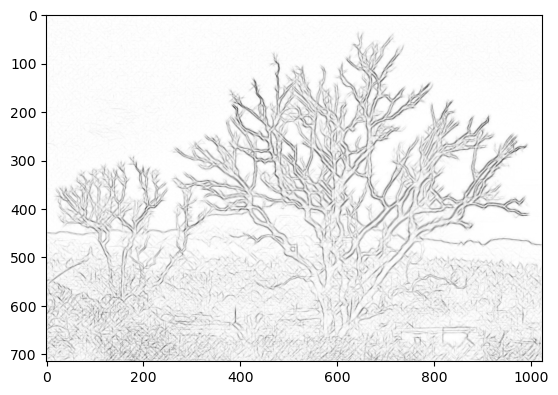

In [9]:
plt.imshow(strokes, cmap='gray')
plt.show()
print('witch multi-res map:\n')
plt.imshow(strokes_mres, cmap='gray')
plt.show()

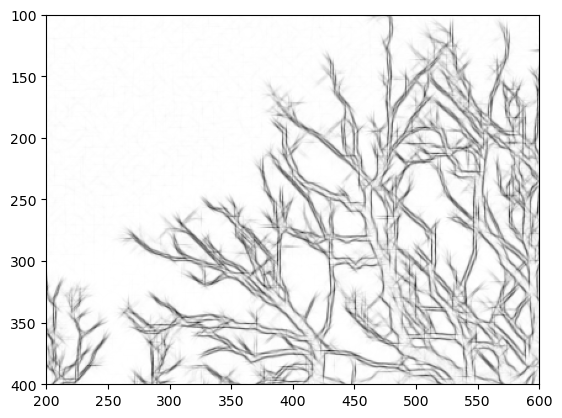

witch multi-res map:



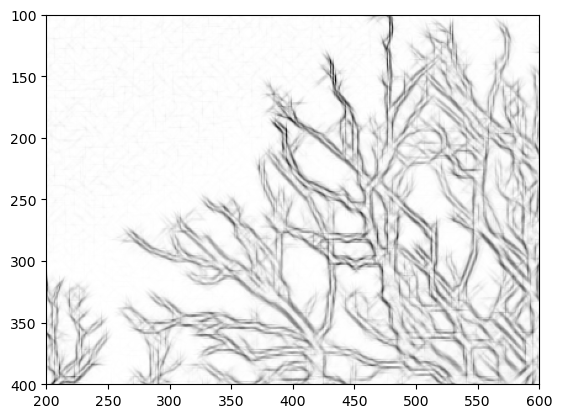

In [10]:
plt.imshow(strokes, cmap='gray') 
plt.xlim(200, 600)
plt.ylim(400,100)
plt.show()
print('witch multi-res map:\n')
plt.imshow(strokes_mres, cmap='gray') 
plt.xlim(200, 600)
plt.ylim(400,100)
plt.show()

In [11]:
edgesC=gen_edge(gray,method=1)
strokesC=gen_strokes(edgesC, lineSize=LS)
edgesS=gen_edge(gray,method=2)
strokesS=gen_strokes(edgesS, lineSize=LS)

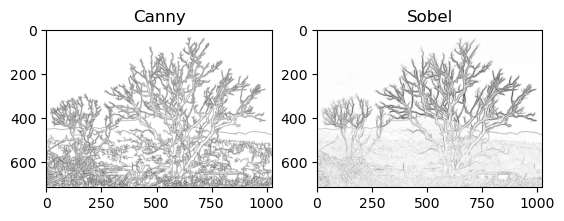

In [12]:
ax1=plt.subplot(221)
ax1.imshow(strokesC,cmap='gray')
ax1.set_title('Canny')
ax2=plt.subplot(222)
ax2.imshow(strokesS,cmap='gray')
ax2.set_title('Sobel')
plt.show()

#plt.imshow(strokesC, cmap='gray')
#plt.show()


## TONE MAP

In [13]:
##TONE MAP
#####Parametros aprendidos paper
w1, w2, w3=52,37,11   #382, 7, 11

desv_b=9
u_a=105
u_b=225
media_d=90
desv_d=11
lap_peak=255
p = np.zeros(256)
Z=0
for i in range(256):
    if i <= lap_peak:
        p1 = w1 * (1 / desv_b) * np.exp(-(255 - i) / desv_b)
    else:
        p1=0

    if (u_a <= i <= u_b):
        p2 = w2* 1 / (u_b - u_a)
    else:
        p2 = 0

    p3 = w3* (1/np.sqrt(2*math.pi*desv_d))*(np.exp(-(i-media_d)**2/(2*desv_d**2)))*0.01
    p[i] = p1 + p2 + p3
    Z=Z+p[i]

p=p/Z

## HISTOGRAM MATCHING

In [14]:
gray=gray/255.0
mres=mres/255.0
from hist_match import hist_match

J=hist_match(gray,p)
J_mres=hist_match(mres,p)
J = filters.gaussian(J, sigma=np.sqrt(2))
J_mres = filters.gaussian(J_mres, sigma=np.sqrt(2))


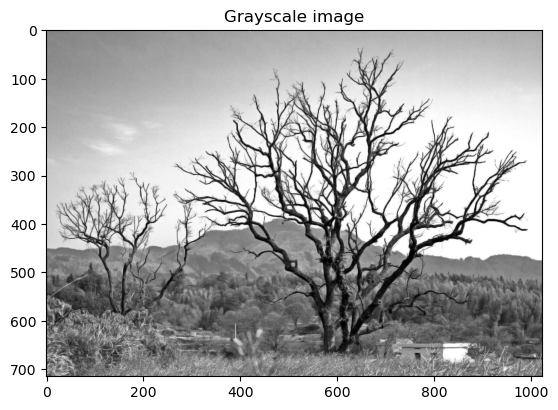

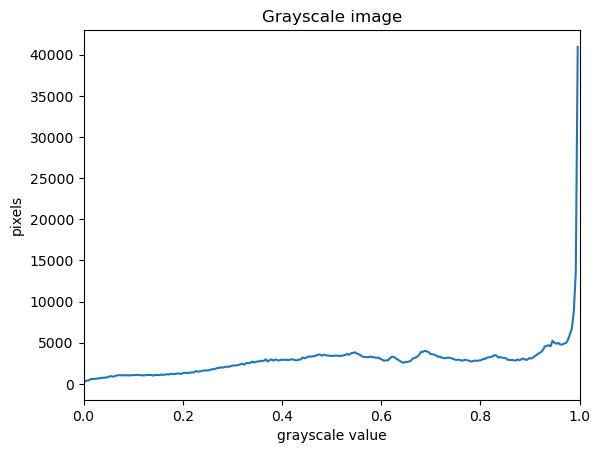

In [15]:
#original
plt.imshow(gray, cmap='gray')
plt.title('Grayscale image')
plt.show()
disp_hist(gray, 'Grayscale image')

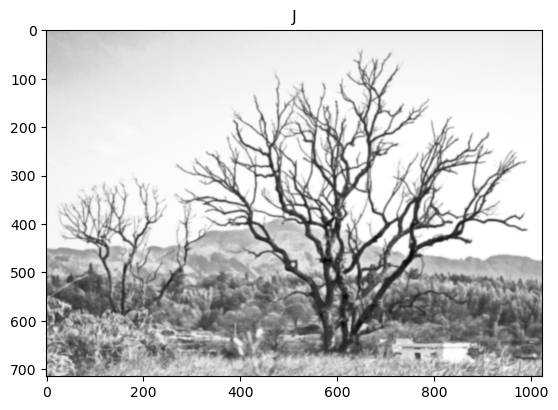

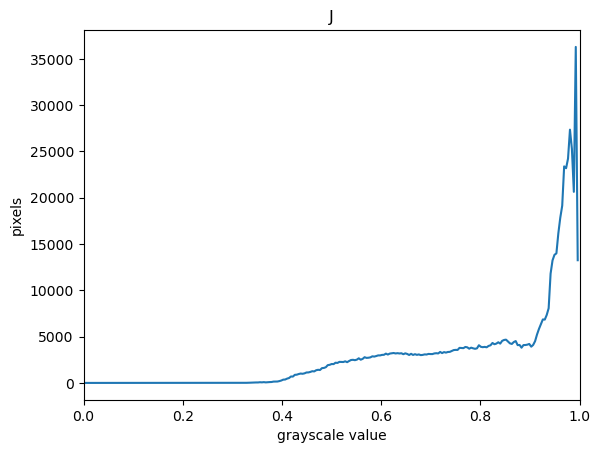

In [16]:
#J
plt.imshow(J, cmap='gray')
plt.title('J')
plt.show()
disp_hist(J, 'J')

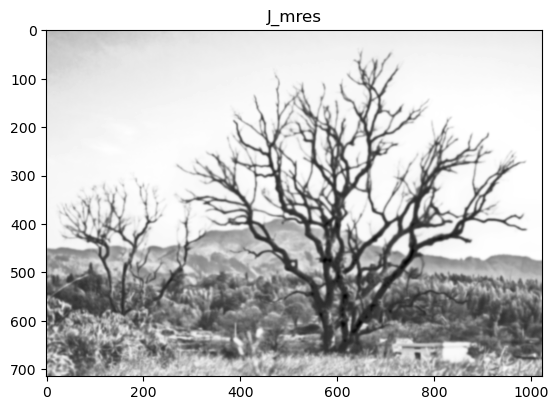

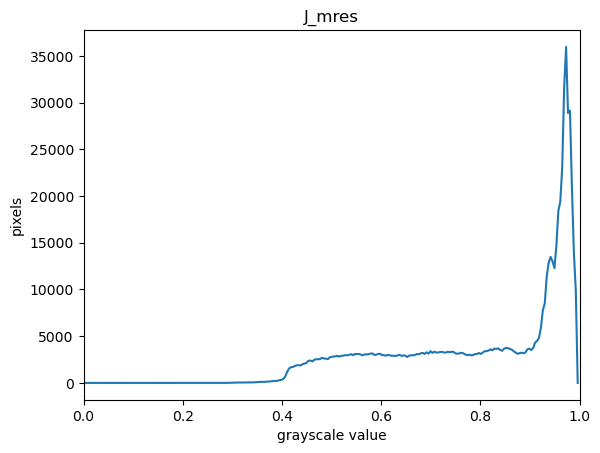

In [17]:
#J_mres
plt.imshow(J_mres, cmap='gray')
plt.title('J_mres')
plt.show()
disp_hist(J_mres, 'J_mres')

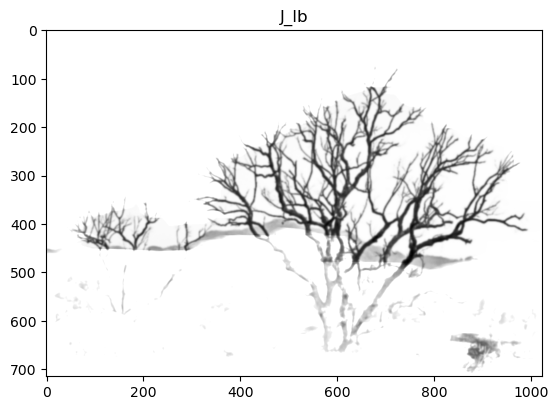

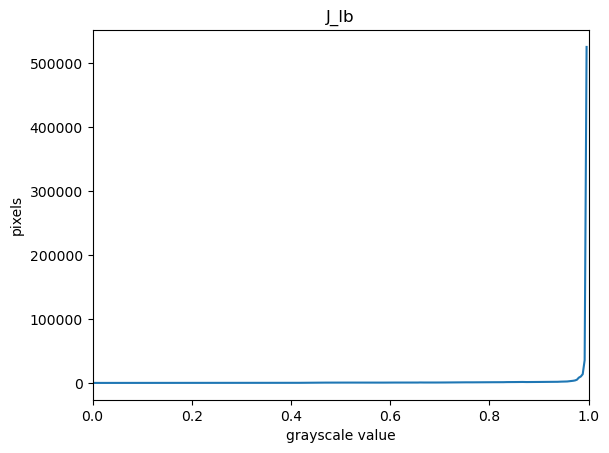

In [18]:
binary=binMap_b

J_lb=np.zeros([height, width]) 
peso=2.0
f=0
for i in range(height):
    for j in range(width):
        if binary[i,j] == 0:
            if peso<2.0:
                peso=peso+0.01
            J_lb[i,j]=np.clip(J[i,j]*peso,0,1)
        elif binary[i,j] == 1:   
            if peso >1.0:
                peso=peso-0.01
            J_lb[i,j]=np.clip(J[i,j]*peso,0,1)
            
plt.imshow(J_lb, cmap='gray')
plt.title('J_lb')
plt.show()
disp_hist(J_lb, 'J_lb')         

## PENCIL RENDERING

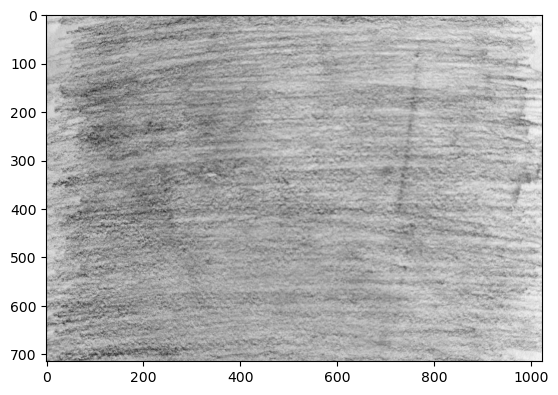

In [19]:
from scipy import  sparse
from gen_pencil_texture import *
H= cv2.imread('pencilTexture/_1.jpg')
H=cv2.cvtColor(H, cv2.COLOR_BGR2GRAY)*(1/255.0)

#Lambda
l = 0.2
# Adjust the input to correspond
H_res = cv2.resize(H, dim)

plt.imshow(H_res, cmap='gray')
plt.show()

H_f=H_res.flatten()
logH = np.log(H_f)

#print('H_f=\n ', H_f)    
#print('logH=\n ', logH)    
J_f= J.flatten()
logJ = np.log(J_f)
    
# In order to use Conjugate Gradient method we need to prepare some sparse matrices:
#print('ravel=\n ', logH.ravel())
logH_sparse = sparse.spdiags(logH, 0, height*width, height*width) # 0 - from main diagonal
#print('logHarr=\n',logH_sparse.toarray())

e = np.ones((height * width, 1))

ee = np.concatenate((-e,e), axis=1)

diags_x = [0, height*width]

diags_y = [0, 1]

ddx = sparse.spdiags(e.T, 0, height*width, height*width)

dddx=sparse.identity(height*width)

dx = sparse.spdiags(ee.T, diags_x, height*width, height*width)

dy = sparse.spdiags(ee.T, diags_y, height*width, height*width)

# Compute matrix X and b: (to solve Ax = b)
A =  l*((dx @ dx.T) + (dy @ dy.T)) + logH_sparse.T @ logH_sparse
#print('A=\n', A)
#print('Aarr =\n', A.toarray())
b = logH_sparse.T @ logJ
#print('b=\n',b )
    
# Conjugate Gradient
beta = sparse.linalg.cg(A, b, tol=1e-6, maxiter=60)
    
# Adjust the result
beta_reshaped = np.reshape(beta[0], (height, width))
    
# The final pencil texture map T
T = np.power(H_res, beta_reshaped)

#T=gen_pencil_texture(J)
T_mres=gen_pencil_texture(H,J_mres)
T_lb=gen_pencil_texture(H,J_lb)
out=np.ones([height, width]) 

for i in range(height):
    for j in range(width):
         if binMap_b[i,j] == 1:
            out[i,j]=T[i,j]

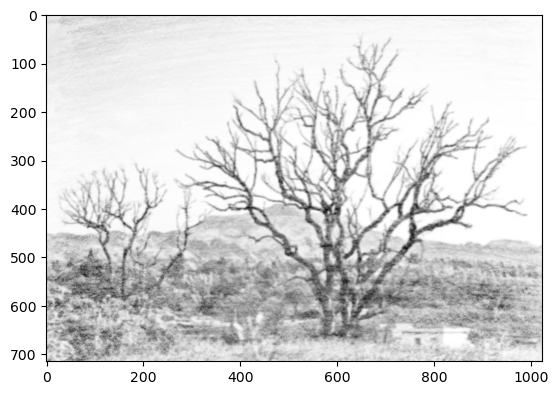

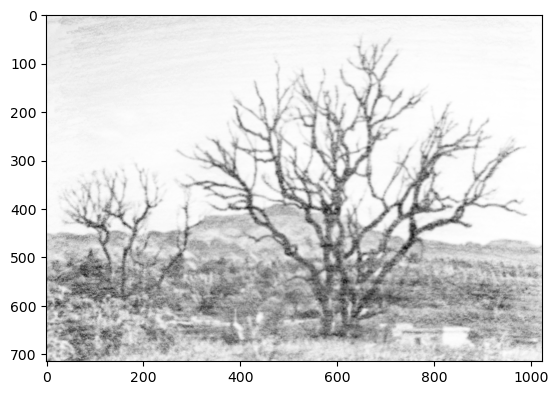

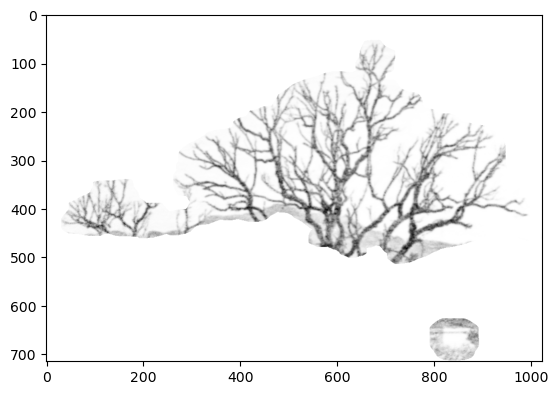

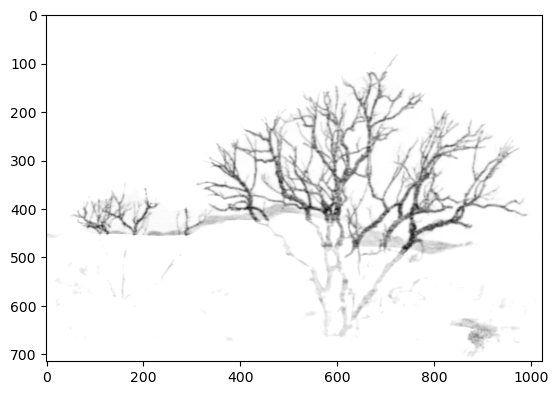

In [20]:
plt.imshow(T, cmap='gray')
plt.show()
plt.imshow(T_mres, cmap='gray')
plt.show()
plt.imshow(out, cmap='gray')
plt.show()
plt.imshow(T_lb, cmap='gray')
plt.show()

S=
 [[0.98212198 0.98965158 0.98949672 ... 0.99682899 0.99803369 0.99714216]
 [0.98639141 0.99360385 0.99680979 ... 0.99547697 0.99466789 0.99490283]
 [0.98941178 0.99380547 0.99441243 ... 0.99399694 0.99221913 0.99675353]
 ...
 [0.88926162 0.86753816 0.90311133 ... 0.97536826 0.93001797 0.96715515]
 [0.90683599 0.90064397 0.93847337 ... 0.86685906 0.8577144  0.89640736]
 [0.93198007 0.94004836 0.95038061 ... 0.97165304 0.93021008 0.97633815]]
T=
 [[0.97195634 0.96294828 0.96006308 ... 0.99183523 0.98948636 0.98585195]
 [0.96328279 0.95839874 0.95742377 ... 0.99192544 0.98956792 0.98585318]
 [0.96145986 0.95633794 0.95563918 ... 0.99211654 0.98993218 0.98655085]
 ...
 [0.9410854  0.91578001 0.8885142  ... 0.96985187 0.97329812 0.97464929]
 [0.93159774 0.90665909 0.86760179 ... 0.96474036 0.96764149 0.96920436]
 [0.92642069 0.9125356  0.8788443  ... 0.95575164 0.9611487  0.95788279]]
R=
 [[0.95457969 0.9529833  0.94997927 ... 0.98869011 0.98754073 0.98303455]
 [0.95017387 0.95226868 0.9

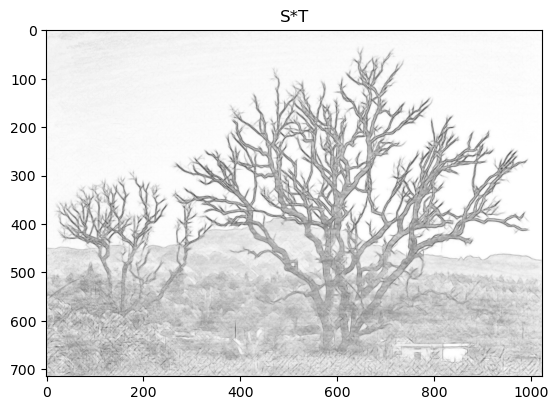

True

In [21]:
S=strokes
print('S=\n', strokes)
print('T=\n', T)

R=np.clip(np.multiply(S,T),0,1)
print('R=\n', R)

plt.imshow(R, cmap='gray')
plt.title('S*T')
plt.show()
cv2.imwrite('output/'+id+'/S_T.jpg', R*255)

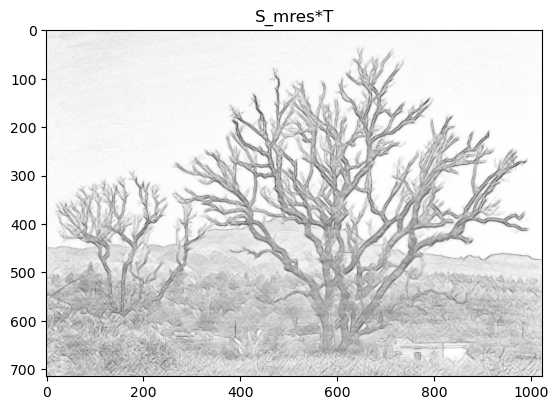

True

In [22]:
R_=np.clip(np.multiply(strokes_mres,T),0,1)
plt.imshow(R_, cmap='gray')
plt.title('S_mres*T')
plt.show()
cv2.imwrite('output/'+id+'/S_mres_T.jpg', R_*255)

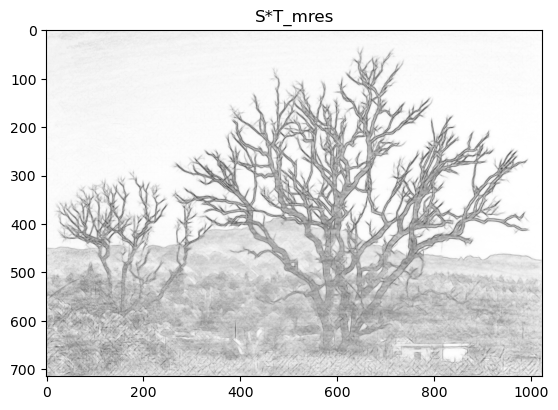

True

In [23]:
R_=np.clip(np.multiply(S,T_mres),0,1)

plt.imshow(R_, cmap='gray')
plt.title('S*T_mres')
plt.show()
cv2.imwrite('output/'+id+'/S_T_mres.jpg', R_*255)

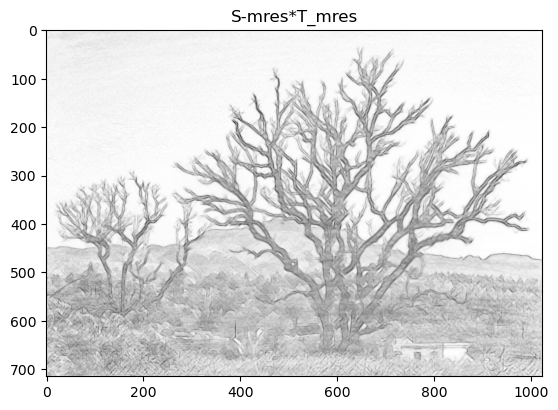

True

In [24]:
R_=np.clip(np.multiply(strokes_mres,T_mres),0,1)

plt.imshow(R_, cmap='gray')
plt.title('S-mres*T_mres')
plt.show()
cv2.imwrite('output/'+id+'/S_mres_T_mres.jpg', R_*255)

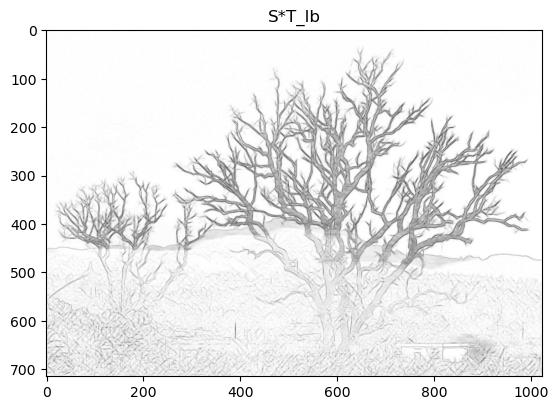

True

In [25]:
R_=np.clip(np.multiply(S,T_lb),0,1)
plt.imshow(R_, cmap='gray')
plt.title('S*T_lb')
plt.show()
cv2.imwrite('output/'+id+'/S_T_lb.jpg', R_*255)

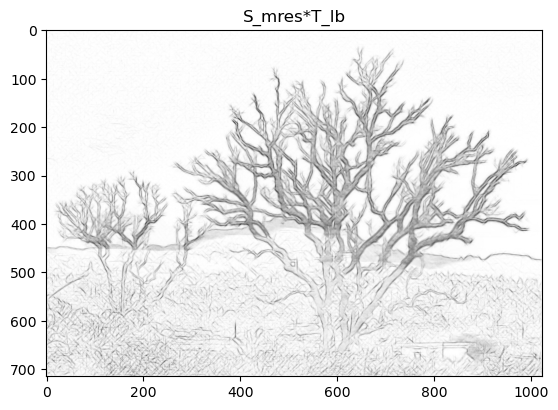

True

In [26]:
R_=np.clip(np.multiply(strokes_mres,T_lb),0,1)

plt.imshow(R_, cmap='gray')
plt.title('S_mres*T_lb')
plt.show()
cv2.imwrite('output/'+id+'/S_mres_T_lb.jpg', R_*255)

## OTRO

In [27]:
R_lb=np.zeros([height, width]) 
peso=2.0
f=0
for i in range(height):
    for j in range(width):
        if binMap_b[i,j] == 0:
            if peso<2.0:
                peso=peso+0.01
            R_lb[i,j]=np.clip(R[i,j]*peso,0,1)
        elif binMap_b[i,j] == 1:   
            if peso >1.0:
                peso=peso-0.01
            R_lb[i,j]=np.clip(R[i,j]*peso,0,1)
            



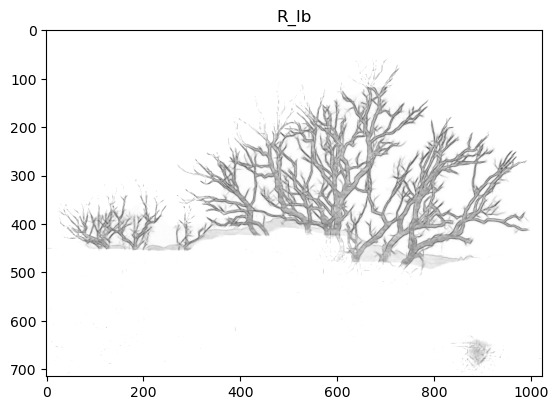

True

In [28]:
plt.imshow(R_lb, cmap='gray')
plt.title('R_lb')
plt.show()

cv2.imwrite('output/'+id+'/R_lb.jpg', R_lb*255)